# Implementatation of ridge regression

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

### Load the training data into feature matrix, class labels, and event ids:

In [135]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

Excluding at the moment all the columns that contains NaN (Data set to zero or -999)

In [ ]:
def exclude_NaN(tX):
    sort_no_NaN= [1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,28,29]
    tX_reduced = tX[:,sort_no_NaN]
    return tX_reduced
tX = exclude_NaN(tX)
tX.shape

In [142]:
def sanitize_NaN(tX):
    x = tX.copy()
    negative_NaN_table = np.array([0,4,5,6,12,23,24,25,26,27,28])
    NEGATIVE_NAN = -999.0
    zero_NaN_table = [29]
    ZERO_NAN = 0
    for row in negative_NaN_table:
        x_without_nan = x[:,row][np.where(x[:,row] != NEGATIVE_NAN)]
        x[:,row][np.where(x[:,row] == NEGATIVE_NAN)] = np.median(x_without_nan)
    for row in zero_NaN_table:
        x_without_nan = x[:,row][np.where(x[:,row] != ZERO_NAN)]
        x[:,row][np.where(x[:,row] == NEGATIVE_NAN)] = np.median(x_without_nan)
    return x

tX = sanitize_NaN(tX)       

In [143]:
print(tX[1:10,0])
np.mean(tX[:,0][np.where(tX[:,0]!=-999.0)])

[ 160.937  112.406  143.905  175.864   89.744  148.754  154.916  105.594
  128.053]


120.41743369599999

In [144]:
np.mean(tX2[:,0])

120.41743369599999

Normalization of the data, to get 0 mean and unit variance

In [ ]:
def normalize(tX):
    return (tX-np.mean(tX,axis=0))/np.std(tX,axis=0)

tX = normalize(tX)

#We verify whether our data have really mean 0 and variance 1
print(np.mean(tX,axis=0))
print(np.std(tX,axis=0))

### Now let us turn to the proper machine learning side of the problem

Function that builds a polynomial basis from each of the data entry (i.e. goes from $\mathbb{R}^N$ to $\mathbb{R}^{N\cdot D + 1}$ for each data point)

In [8]:
def new_build_poly(x, degree):
    """polynomial basis function."""
    # Creates the matrix with the degrees we want to apply to our data x
    # replecating the vector with [1 2 3 4 ... degree] to a matrix
    #degree_mat = np.tile(list(range(0,degree+1)), (len(x), 1))
    #return np.transpose(np.power(x,np.transpose(degree_mat)))
    
    # Only 1 time 1, because we don't need it to be repeated. That's why for M features and a polynomial of degree D,
    # we will get M*D+1 entries.
    X=np.zeros((x.shape[0],(degree)*x.shape[1]+1))
    for i in range(1,degree+1):
        for j in range(x.shape[1]):
            #print((i-1)*(x.shape[1])+j+1)
            X[:,(i-1)*x.shape[1]+j+1]=x[:,j]**i
    X[:,0]=1
    return X

Implementing 4-fold cross-validation in the following two methods

In [9]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [10]:
from costs import compute_mse
from ridge_regression import ridge_regression

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train: 
    # ***************************************************
    x_train = np.array(x[k_indices[k-1]])
    y_train = np.array(y[k_indices[k-1]])
    x_test = np.empty((0,x.shape[1]))
    y_test =  np.empty((0,1))
    for k_iter,validation_points in enumerate(k_indices):
        if(k_iter!=k-1):
            x_test=np.append(x_test,x[validation_points],axis=0)
            y_test=np.append(y_test,y[validation_points])
    #print(x_test.shape)
    #print(y_test.shape)
    # ***************************************************
    # form data with polynomial degree:
    # ***************************************************
    x_train_poly = new_build_poly(x_train,degree)
    x_test_poly = new_build_poly(x_test,degree)
    # ***************************************************
    # ridge regression: 
    # ***************************************************
    w_rr = ridge_regression(y_train,x_train_poly,lambda_)
    # ***************************************************
    # calculate the loss for train and test data:
    # ***************************************************
    #print(x_train_poly.dot(w_rr).shape)
    #print(y_train.shape)
    loss_tr = np.sqrt(2*compute_mse(y_train,x_train_poly,w_rr))
    loss_te = np.sqrt(2*compute_mse(y_test,x_test_poly,w_rr))
    return loss_tr, loss_te

Implementation of the ridge regression

In [11]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    return np.linalg.solve(np.dot(tx.T,tx)+lamb*np.identity(tx.shape[1]),np.dot(tx.T,y))#/(2*len(tx))

In [12]:
def run_ridge_regression(y, tX):
    """ridge regression running script."""
    
    # define parameters for our run   
    seed = 6
    degree = 2
    split_ratio = 0.5
    lambdas = np.logspace(-4, 2, 20)   
    weights_arr = np.zeros((len(lambdas),(degree)*tX.shape[1]+1))
    errors = []
    # ***************************************************
    # train on the whole data and use polynomial basis functions
    # ***************************************************
    tX_train = build_poly(tX, degree)
    
    # ***************************************************
    # ridge regression with different lambdas: 
    # ***************************************************
    for i,lambd in enumerate(lambdas):
        #print(weights_arr[i,:].shape, ' ',X_train.shape)
        weights_arr[i,:] = ridge_regression(y,tX_train,lambd)
        
        #rmse_tr[i] = np.sqrt(2*co.compute_loss(y_train,X_train,weights_arr[i,:]))
        #rmse_te[i] = np.sqrt(2*co.compute_loss(y_test,X_test,weights_arr[i,:]))
                
        #print("lambda ={l}, proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
        #        l=lambd,p=ratio, d=degree, tr=rmse_tr[i], te=rmse_te[i]))
    return weights_arr, errors

weights_arr, errors = run_ridge_regression(y, tX)


NameError: name 'build_poly' is not defined


 Testing for a polynomial of degree  1
lambda= 0.0001, RMSE_BEST_VALUE :  1.03102842879, lambda= 0.000133, RMSE_BEST_VALUE :  1.03102826064, lambda= 0.000176, RMSE_BEST_VALUE :  1.03102804206, lambda= 0.000233, RMSE_BEST_VALUE :  1.03102776077, lambda= 0.000309, RMSE_BEST_VALUE :  1.03102740188, lambda= 0.000409, RMSE_BEST_VALUE :  1.03102694945, lambda= 0.000543, RMSE_BEST_VALUE :  1.03102638741, lambda= 0.00072, RMSE_BEST_VALUE :  1.0310257021, lambda= 0.000954, RMSE_BEST_VALUE :  1.03102488577, lambda= 0.001265, RMSE_BEST_VALUE :  1.0310239406, lambda= 0.001677, RMSE_BEST_VALUE :  1.03102288308, lambda= 0.002223, RMSE_BEST_VALUE :  1.0310217457, lambda= 0.002947, RMSE_BEST_VALUE :  1.03102057574, lambda= 0.003907, RMSE_BEST_VALUE :  1.03101942881, lambda= 0.005179, RMSE_BEST_VALUE :  1.03101835977, lambda= 0.006866, RMSE_BEST_VALUE :  1.03101741234, lambda= 0.009103, RMSE_BEST_VALUE :  1.03101661134, lambda= 0.012068, RMSE_BEST_VALUE :  1.03101596239, lambda= 0.015999, RMSE_BEST_VA

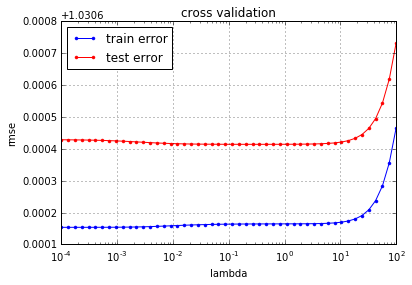

In [152]:
from plots import cross_validation_visualization 

def cross_validation_rr():
    seed = 1
    #degrees = range(2,11)
    degrees = np.array([1])
    k_fold = 4
    lambdas = np.logspace(-4, 2, 50)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    # ***************************************************
    # cross validation:
    # ***************************************************    
    rmse_best = np.zeros(len(degrees))
    rmse_best_lambda = np.zeros(len(degrees))
    for j,degree in enumerate(degrees):
        print('\n Testing for a polynomial of degree ', degree)
        rmse_tr = np.zeros(len(lambdas))
        rmse_te = np.zeros(len(lambdas))
        for i,lambda_ in enumerate(lambdas):
            print('lambda=',round(lambda_,6),end=", ")
            loss_tr_tot=0
            loss_te_tot=0
            for k in range(k_fold+1):
                loss_tr_tmp,loss_te_tmp =cross_validation(y,tX,k_indices,k,lambda_,degree)
                loss_tr_tot += loss_tr_tmp
                loss_te_tot += loss_te_tmp
            rmse_tr[i] = loss_tr_tot/k_fold
            rmse_te[i] = loss_te_tot/k_fold
            print('RMSE_BEST_VALUE : ',rmse_te[i])
        rmse_best[j] = min(rmse_te)
        rmse_best_lambda[j] = lambdas[int(np.argmin(rmse_te))]
        cross_validation_visualization(lambdas, rmse_tr, rmse_te)
        
    print('\nBest error :',rmse_best)
    print('Best lambda :',rmse_best_lambda)
    return rmse_best,rmse_best_lambda
    #plt.figure()
    #plt.plot(degrees,rmse_best)

rmse,lambda_ = cross_validation_rr()

In [155]:
w = ridge_regression(y, tX, lambda_[0])

In [157]:
len(w)

30